In [22]:
import numpy as np
import sympy as sp
from scipy.optimize import brentq
import pickle
from tqdm import tqdm
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib widget
from functions.simulation_functions import param_scan
import nbimporter
from theory import rec_mean, rec_var

In [23]:
# run a paramater scan across p and q values
ics_mu     = np.array([1, 0])           # start with one sensitive cell and zero resistant cells
ics_var    = np.array([0, 0, 0])        # since we have a deterministic initial population, the variance is 0
num_gens   = 30                         # simulate for 10 generations
num_trials = 10000                      # run 10,000 trials for each parameter pair

p_vals = np.arange(0, 1.05, 0.05)   # vary p from 0 to 1 with 0.05 increments
q_vals = np.arange(0, 1.05, 0.05)   # vary p from 0 to 1 with 0.05 increments

sim_data = param_scan(ics_mu, num_gens, num_trials, p_vals, q_vals) # index using `sim_data[p_idx, q_idx, trial#, gen#, cell_type]`

Simulating (p, q) pairs: 100%|██████████| 441/441 [00:54<00:00,  8.15it/s]


In [24]:
# open theory expressions for µ_n and v_n:
theory_dir = './thr_output'
with open(os.path.join(theory_dir, 'mu_n.pkl'), 'rb') as file:
    mu_n = pickle.load(file)
with open(os.path.join(theory_dir, 'v_n.pkl'), 'rb') as file:
    v_n  = pickle.load(file)

# p, q: real numbers in [0, 1]
p = sp.Symbol('p', real=True, nonnegative=True)    # probability of becoming resistant from sensitive
q = sp.Symbol('q', real=True, nonnegative=True)    # probability of becoming sensitive from resistant

# n: integer
n = sp.Symbol('n', integer=True, nonnegative=True) # number of generations

# initial conditions for mean, µ0_1, µ0_2: real numbers
mu_0_S = sp.Symbol('\mu_0^{(S)}', real=True, nonnegative=True)
mu_0_R = sp.Symbol('\mu_0^{(R)}', real=True, nonnegative=True)
mu_0   = sp.Matrix([[mu_0_S], [mu_0_R]])

# initial conditions for variance, v0_1, v0_2, v0_3: real numbers
v_0_S  = sp.Symbol('v_0^{(S)}', real=True, nonnegative=True)
v_0_SR = sp.Symbol('v_0^{(SR)}', real=True, nonnegative=True)
v_0_R  = sp.Symbol('v_0^{(R)}', real=True, nonnegative=True)
v_0    = sp.Matrix([[v_0_S], [v_0_SR], [v_0_R]])

# convert the symbolic expressions into numerical expressions
# which are faster to compute
mu_n_num = sp.lambdify([p, q, n, mu_0_S, mu_0_R], mu_n)

v_n_num  = sp.lambdify([p, q, n, mu_0_S, mu_0_R, v_0_S, v_0_SR, v_0_R], v_n)

In [25]:
# DEFINE 'universal' mu_n and v_n functions that stitch together the numeric solution from sympy and the recurrent solution
# to ensure compatibility with all parameter ranges. These universal functions also work for scalar or vector inputs.

def uni_mu_n(P, Q, n_val, u0, epsilon=1e-15):
    if (isinstance(P, np.ndarray)) and (isinstance(Q, np.ndarray)):
        output = np.empty((2, P.shape[0], P.shape[1]))

        for i, p_val in enumerate(tqdm(P[:, 0])):
            for j, q_val in enumerate(Q[0, :]):
                if (abs(p_val + q_val) < epsilon):
                    output[:, i, j] = rec_mean(p_val, q_val, n_val, u0).flatten()
                else:
                    output[:, i, j] = mu_n_num(p_val, q_val, n_val, u0[0], u0[1]).flatten()
        
        return output

    else:
        if (abs(P + Q) < epsilon):
            return rec_mean(P, Q, n_val, u0).flatten()
        else:
            return mu_n_num(P, Q, n_val, u0[0], u0[1]).flatten()
        
def uni_v_n(P, Q, n_val, u0, v0, epsilon=1e-15):
    if (isinstance(P, np.ndarray)) and (isinstance(Q, np.ndarray)):
        output = np.empty((3, P.shape[0], P.shape[1]))

        for i, p_val in enumerate(tqdm(P[:, 0])):
            for j, q_val in enumerate(Q[0, :]):
                if (abs(p_val + q_val) < epsilon) or (abs(p_val + q_val - 1) < epsilon):
                    output[:, i, j] = rec_var(p_val, q_val, n_val, u0, v0).flatten()
                else:
                    output[:, i, j] = v_n_num(p_val, q_val, n_val, u0[0], u0[1], v0[0], v0[1], v0[2]).flatten()
        
        return output

    else:
        if (abs(P + Q) < epsilon) or (abs(P + Q - 1) < epsilon):
            return rec_var(P, Q, n_val, u0, v0).flatten()
        else:
            return v_n_num(P, Q, n_val, u0[0], u0[1], v0[0], v0[1], v0[2]).flatten()

In [26]:
warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore divide by 0 warnings

# calculate the theoretical mean and variances for the simulated parameter sets
thr_data = np.zeros((len(p_vals), len(q_vals), 2, num_gens+1, 2)) # index using `thr_data[p_idx, q_idx, {0: mean, 1: var}, gen#, cell_type]`

# define a small error threshold
epsilon = 1e-15

# computation for one set (p_val, q_val, n_val)
for i, p_val in enumerate(tqdm(p_vals)):
    for j, q_val in enumerate(q_vals):
        for n_val in range(num_gens+1):
            
            uni_mu_n(p_val, q_val, n_val, ics_mu)

            thr_data[i, j, 0, n_val, :] = uni_mu_n(p_val, q_val, n_val, ics_mu)
            thr_data[i, j, 1, n_val, :] = uni_v_n(p_val, q_val, n_val, ics_mu, ics_var)[[0, 2]]

100%|██████████| 21/21 [00:02<00:00,  8.31it/s]


In [27]:
# 1a) compare the simulated and theoretical mean and variances

sim_mean = np.mean(sim_data[:, :, :, num_gens, 1], axis=2)
thr_mean = thr_data[:, :, 0, num_gens, 1]

sim_var  = np.var(sim_data[:, :, :, num_gens, 1], axis=2)
thr_var  = thr_data[:, :, 1, num_gens, 1]

# calculate the absolute and relative error between the means
# if both thr_var and sim_var == 0, set rel_error = 0
# if thr_var == 0 but sim_var != 0, set rel_error = np.nan
mean_abs_error = np.abs(sim_mean - thr_mean)
mean_rel_error = np.where(
    (thr_mean == 0) & (sim_mean == 0), 0.0,
    np.abs(sim_mean - thr_mean) / np.where(thr_mean == 0, np.nan, thr_mean)
)
mean_rel_error *= 100

# calculate the absolute and relative errors between the variances
var_abs_error = np.abs(sim_var - thr_var)
var_rel_error = np.where(
    (thr_var == 0) & (sim_var == 0), 0.0,
    np.abs(sim_var - thr_var) / np.where(thr_var == 0, np.nan, thr_var)
)
var_rel_error *=100

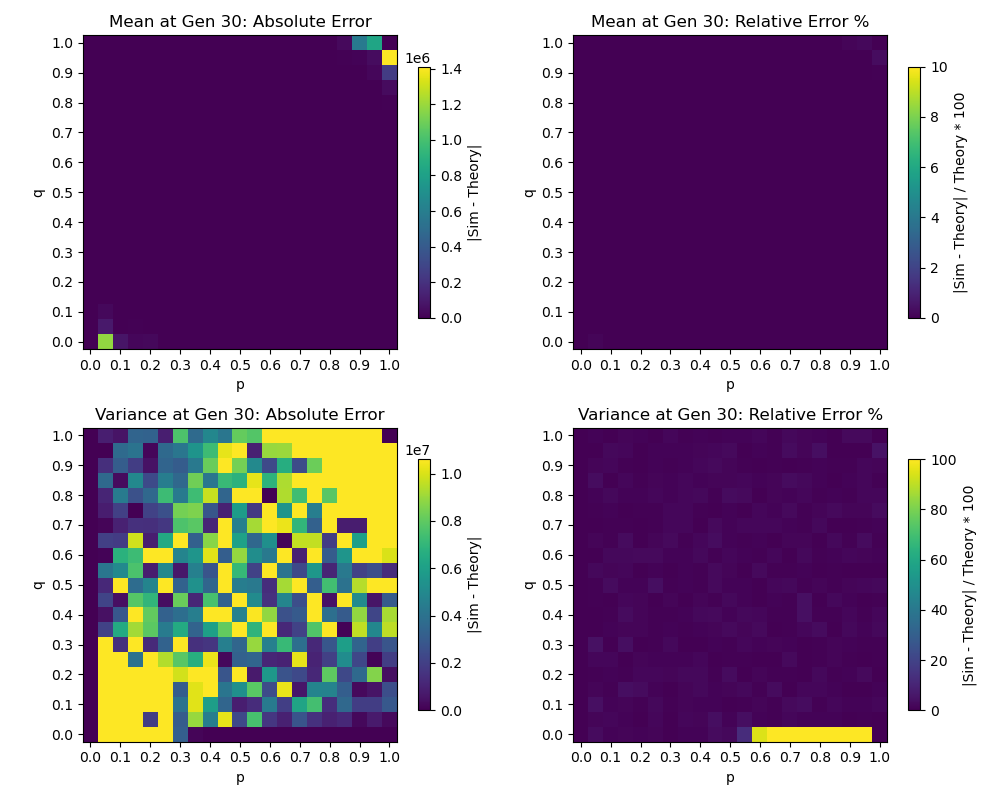

In [28]:
# 1b) visualize error results with a heatmap
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im00 = axs[0, 0].imshow(mean_abs_error.T, origin='lower', vmin=0)
axs[0, 0].set_title(f'Mean at Gen {num_gens}: Absolute Error')
fig.colorbar(im00, ax=axs[0, 0], label='|Sim - Theory|', shrink=0.8)

im01 = axs[0, 1].imshow(mean_rel_error.T, origin='lower', vmin=0, vmax=10)
axs[0, 1].set_title(f'Mean at Gen {num_gens}: Relative Error %')
fig.colorbar(im01, ax=axs[0, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

im10 = axs[1, 0].imshow(var_abs_error.T, origin='lower', vmin=0, vmax=np.percentile(var_abs_error[~np.isnan(var_abs_error)], 75))
axs[1, 0].set_title(f'Variance at Gen {num_gens}: Absolute Error')
fig.colorbar(im10, ax=axs[1, 0], label='|Sim - Theory|', shrink=0.8)

im11 = axs[1, 1].imshow(var_rel_error.T, origin='lower', vmin=0)
axs[1, 1].set_title(f'Variance at Gen {num_gens}: Relative Error %')
fig.colorbar(im11, ax=axs[1, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks(np.arange(len(p_vals))[::2])
        axs[i, j].set_xticklabels(np.round(p_vals[::2], 2))
        axs[i, j].set_xlabel('p')

        axs[i, j].set_yticks(np.arange(len(q_vals))[::2])
        axs[i, j].set_yticklabels(np.round(q_vals[::2], 2))
        axs[i, j].set_ylabel('q')

plt.tight_layout()
plt.show()

In [29]:
def q_star_even(n_val, epsilon=1e-10):
    dmu_n_dp = sp.diff(mu_n.subs({mu_0_S: 1, mu_0_R: 0}), p)
    dmu_n_dp_p1 = sp.simplify(dmu_n_dp.subs({p: 1, n:n_val}))
    
    dmu_n_dp_p1_S_num = sp.lambdify(q, dmu_n_dp_p1[0])
    dmu_n_dp_p1_R_num = sp.lambdify(q, dmu_n_dp_p1[1])

    try:
        result_S = brentq(dmu_n_dp_p1_S_num, epsilon, 1)
        result_R = brentq(dmu_n_dp_p1_R_num, epsilon, 1)

        if (result_S == epsilon) and (result_R == epsilon):
            result_S = np.nan
            result_R = np.nan
        
    except Exception as e:
        result_S = result_R = np.nan

    return np.array([result_S, result_R])

def p_star_even(n_val, epsilon=1e-10):
    d2mu_n_dq2 = sp.diff(mu_n.subs({mu_0_S: 1, mu_0_R: 0}), q, q)
    d2mu_n_dq2_q1 = sp.simplify(d2mu_n_dq2.subs({q: 1, n:n_val}))
    
    d2mu_dq2_q1_S_num = sp.lambdify(p, d2mu_n_dq2_q1[0])
    d2mu_dq2_q1_R_num = sp.lambdify(p, d2mu_n_dq2_q1[1])

    try:
        result_S = brentq(d2mu_dq2_q1_S_num, epsilon, 1)
        result_R = brentq(d2mu_dq2_q1_R_num, epsilon, 1)

        if (result_S == epsilon) and (result_R == epsilon):
            result_S = np.nan
            result_R = np.nan
        
    except Exception as e:
        result_S = result_R = np.nan

    return np.array([result_S, result_R])

def q_star_odd(n_val, epsilon=1e-10):
    d2mu_n_dp2 = sp.diff(mu_n.subs({mu_0_S: 1, mu_0_R: 0}), p, p)
    d2mu_n_dp2_p1 = sp.simplify(d2mu_n_dp2.subs({p: 1, n:n_val}))
    
    d2mu_dp2_p1_S_num = sp.lambdify(q, d2mu_n_dp2_p1[0])
    d2mu_dp2_p1_R_num = sp.lambdify(q, d2mu_n_dp2_p1[1])

    try:
        result_S = brentq(d2mu_dp2_p1_S_num, epsilon, 1)
        result_R = brentq(d2mu_dp2_p1_R_num, epsilon, 1)

        if (result_S == epsilon) and (result_R == epsilon):
            result_S = np.nan
            result_R = np.nan
        
    except Exception as e:
        result_S = result_R = np.nan
        print('error')

    return np.array([result_S, result_R])

def p_star_odd(n_val, epsilon=1e-10):
    dmu_n_dq = sp.diff(mu_n.subs({mu_0_S: 1, mu_0_R: 0}), q)
    dmu_n_dq_q1 = sp.simplify(dmu_n_dq.subs({q: 1, n:n_val}))
    
    dmu_n_dq_q1_S_num = sp.lambdify(p, dmu_n_dq_q1[0])
    dmu_n_dq_q1_R_num = sp.lambdify(p, dmu_n_dq_q1[1])

    try:
        result_S = brentq(dmu_n_dq_q1_S_num, epsilon, 1)
        result_R = brentq(dmu_n_dq_q1_R_num, epsilon, 1)

        if (result_S == epsilon) and (result_R == epsilon):
            result_S = np.nan
            result_R = np.nan
        
    except Exception as e:
        result_S = result_R = np.nan

    return np.array([result_S, result_R])


def phase_point(n_val, epsilon=1e-10):
    if n_val % 2 == 0:
        q_star = q_star_even(n_val)
        p_star = p_star_even(n_val)
    else:
        q_star = q_star_odd(n_val)
        p_star = p_star_odd(n_val)

    if (q_star[0] - q_star[1] < epsilon) and (p_star[0] - p_star[1] < epsilon):
        return np.array([p_star[0], q_star[0]])

    else:
        return None

In [30]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

pq_vals = np.arange(0, 1.05, 0.05)
Q, P = np.meshgrid(pq_vals, pq_vals)

n_val   = 4
ics_mu  = np.array([1, 0])
ics_var = np.array([0, 0, 0])

U4 = uni_mu_n(P, Q, n_val, ics_mu)
V4 = uni_v_n(P, Q, n_val, ics_mu, ics_var)
p_star_4, q_star_4 = phase_point(n_val)
p_star_4_mu_line = np.zeros((2, pq_vals.shape[0]))
q_star_4_mu_line = np.zeros((2, pq_vals.shape[0]))
q_star_4_var_line = np.zeros((3, pq_vals.shape[0]))
p_star_4_var_line = np.zeros((3, pq_vals.shape[0]))

U5 = uni_mu_n(P, Q, n_val+1, ics_mu)
V5 = uni_v_n(P, Q, n_val+1, ics_mu, ics_var)
p_star_5, q_star_5 = phase_point(n_val+1)
p_star_5_mu_line = np.zeros((2, pq_vals.shape[0]))
q_star_5_mu_line = np.zeros((2, pq_vals.shape[0]))
q_star_5_var_line = np.zeros((3, pq_vals.shape[0]))
p_star_5_var_line = np.zeros((3, pq_vals.shape[0]))

for i, p_val in enumerate(pq_vals):
    q_star_4_mu_line[:, i] = uni_mu_n(p_val, q_star_4, n_val, ics_mu)
    q_star_4_var_line[:, i] = uni_v_n(p_val, q_star_4, n_val, ics_mu, ics_var)
    q_star_5_mu_line[:, i] = uni_mu_n(p_val, q_star_5, n_val+1, ics_mu)
    q_star_5_var_line[:, i] = uni_v_n(p_val, q_star_5, n_val+1, ics_mu, ics_var)

for j, q_val in enumerate(pq_vals):
    p_star_4_mu_line[:, j] = uni_mu_n(p_star_4, q_val, n_val, ics_mu)
    p_star_4_var_line[:, i] = uni_v_n(p_star_4, q_val, n_val, ics_mu, ics_var)
    p_star_5_mu_line[:, j] = uni_mu_n(p_star_5, q_val, n_val+1, ics_mu)
    p_star_5_var_line[:, i] = uni_v_n(p_star_5, q_val, n_val+1, ics_mu, ics_var)

if np.isnan(U4).sum() + np.isnan(V4).sum() + np.isnan(U5).sum() + np.isnan(V5).sum() > 0:
    print('Error: some parameter set resulted in a np.nan output.')

100%|██████████| 21/21 [00:00<00:00, 279.95it/s]


In [31]:
max_indices = np.argmax(U4[1, :, :], axis=1)
U4_max = (U4[1, :, :])[max_indices]
P_max = P[max_indices]
Q_max = Q[max_indices]

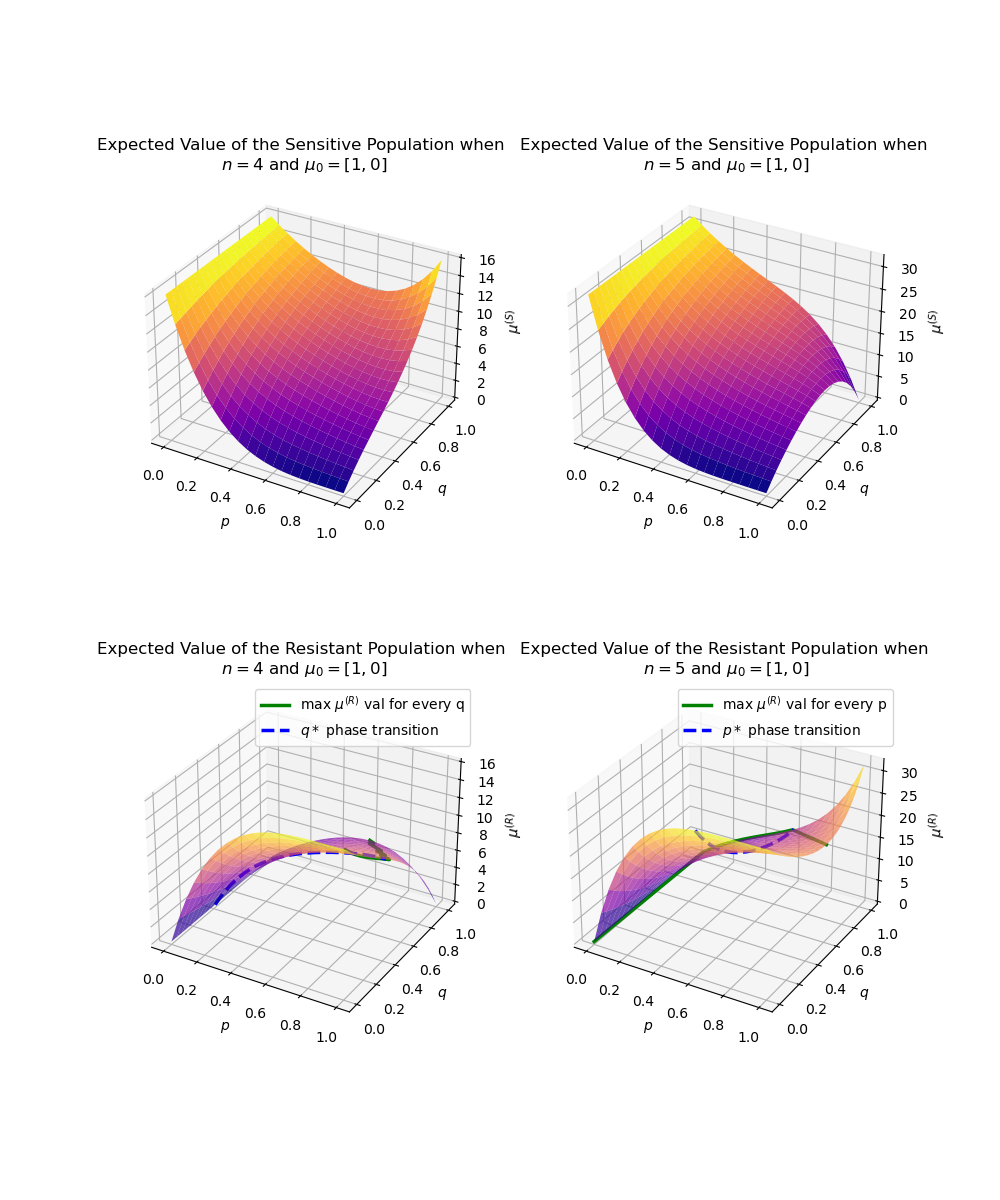

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12), subplot_kw={"projection": "3d"})
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.plot_surface(P, Q, U4[0, :, :], cmap='plasma')
ax1.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$\mu^{(S)}$')
ax1.set_title(rf'Expected Value of the Sensitive Population when' + 
              '\n' +  
              rf' $n={n_val}$ and $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$')

ax2.plot_surface(P, Q, U5[0, :, :], cmap='plasma')
ax2.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$\mu^{(S)}$')
ax2.set_title(rf'Expected Value of the Sensitive Population when' + 
              '\n' +  
              rf' $n={n_val+1}$ and $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$')

ax3.plot(pq_vals[np.argmax(U4[1, :, :], axis=0)], pq_vals, np.max(U4[1, :, :], axis=0), color='green', linewidth='2.5', label=r'max $\mu^{(R)}$ val for every q')
ax3.plot(pq_vals, q_star_4 * np.ones(pq_vals.shape), q_star_4_mu_line[1, :], color='blue', linestyle='--', linewidth='2.5', label =r'$q*$ phase transition')
ax3.plot_surface(P, Q, U4[1, :, :], cmap='plasma', alpha=0.7)
ax3.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$\mu^{(R)}$')
ax3.set_title(rf'Expected Value of the Resistant Population when' + 
              '\n' +  
              rf' $n={n_val}$ and $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$')
ax3.legend()

ax4.plot(pq_vals, pq_vals[np.argmin(U5[1, :, :], axis=1)], np.min(U5[1, :, :], axis=1), color='green', linewidth='2.5', label=r'max $\mu^{(R)}$ val for every p')
ax4.plot(p_star_5 * np.ones(pq_vals.shape), pq_vals, p_star_5_mu_line[1, :], color='blue', linestyle='--', linewidth='2.5', label=r'$p*$ phase transition')
ax4.plot_surface(P, Q, U5[1, :, :], cmap='plasma', alpha=0.7)
ax4.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$\mu^{(R)}$')
ax4.set_title(rf'Expected Value of the Resistant Population when' + 
              '\n' +  
              rf' $n={n_val+1}$ and $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$')
ax4.legend()


plt.show()

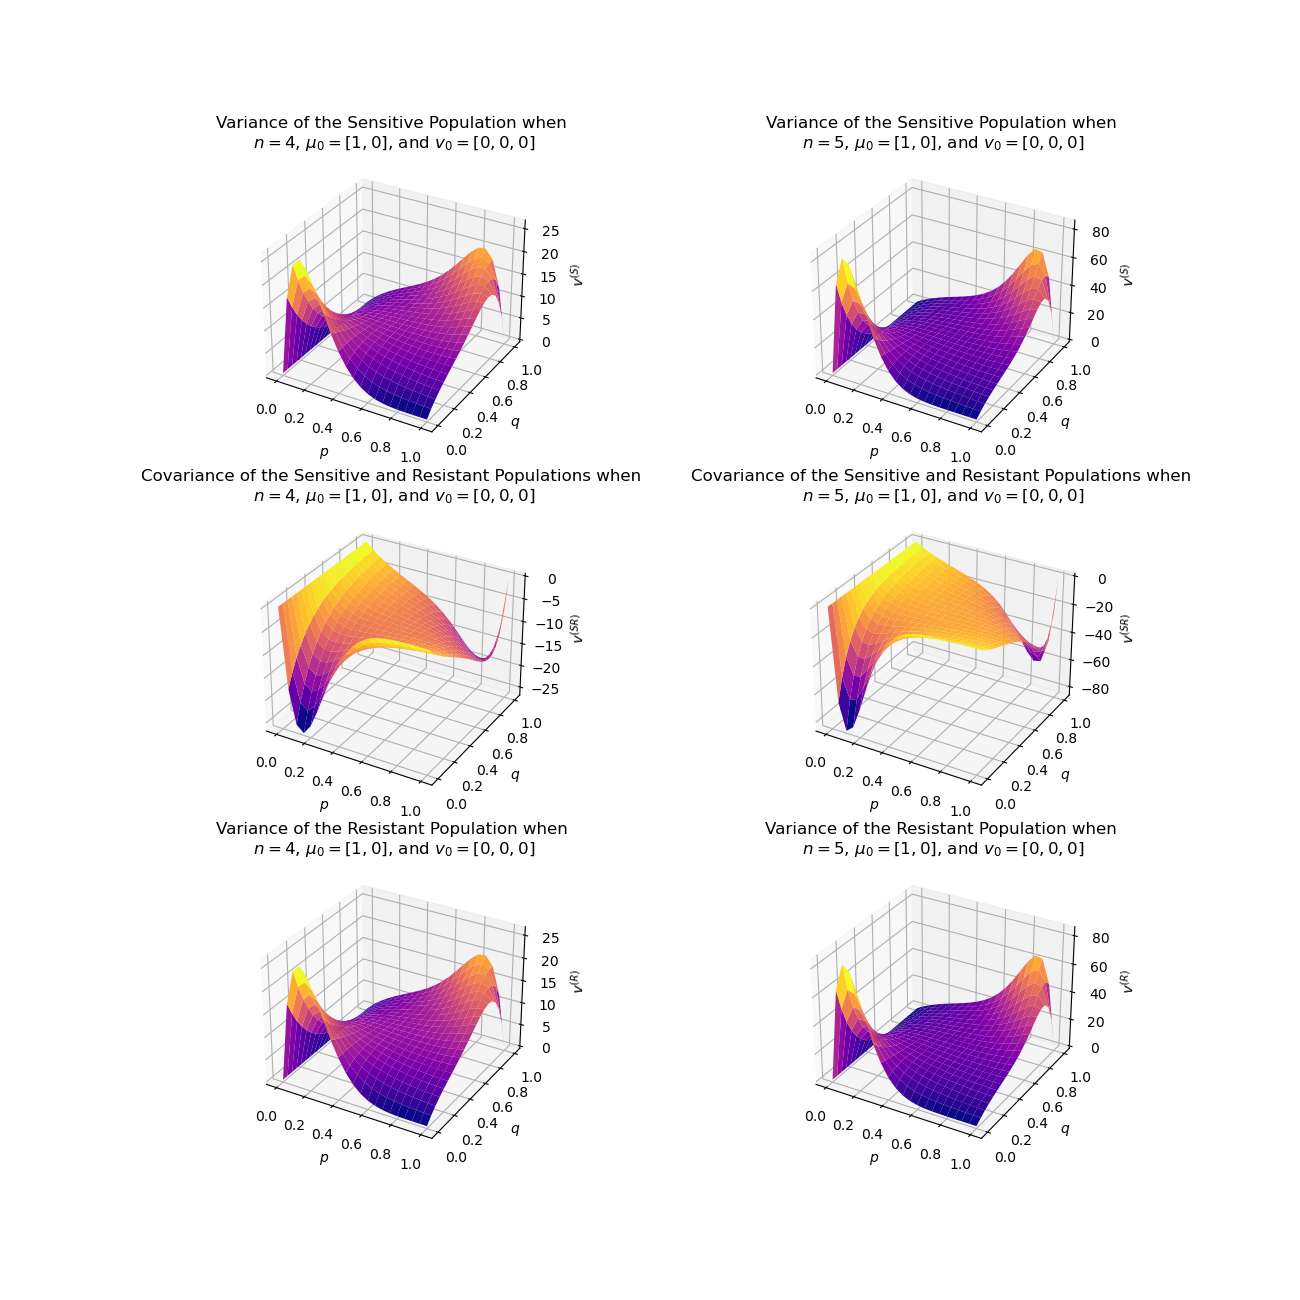

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(13, 13), subplot_kw={"projection": "3d"})
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1,1]
ax5 = axs[2, 0]
ax6 = axs[2, 1]

ax1.plot_surface(P, Q, V4[0, :, :], cmap='plasma')
ax1.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(S)}$')
ax1.set_title(rf'Variance of the Sensitive Population when' + 
              '\n' +  
              rf' $n={n_val}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')

ax2.plot_surface(P, Q, V5[0, :, :], cmap='plasma')
ax2.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(S)}$')
ax2.set_title(rf'Variance of the Sensitive Population when' + 
              '\n' +  
              rf' $n={n_val+1}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')

ax3.plot_surface(P, Q, V4[1, :, :], cmap='plasma')
ax3.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(SR)}$')
ax3.set_title(rf'Covariance of the Sensitive and Resistant Populations when' + 
              '\n' +  
              rf' $n={n_val}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')

ax4.plot_surface(P, Q, V5[1, :, :], cmap='plasma')
ax4.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(SR)}$')
ax4.set_title(rf'Covariance of the Sensitive and Resistant Populations when' + 
              '\n' +  
              rf' $n={n_val+1}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')

ax5.plot_surface(P, Q, V4[2, :, :], cmap='plasma')
ax5.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(R)}$')
ax5.set_title(rf'Variance of the Resistant Population when' + 
              '\n' +  
              rf' $n={n_val}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')
              

ax6.plot_surface(P, Q, V5[2, :, :], cmap='plasma')
ax6.set(xlabel=r'$p$', ylabel=r'$q$', zlabel=r'$v^{(R)}$')
ax6.set_title(rf'Variance of the Resistant Population when' + 
              '\n' +  
              rf' $n={n_val+1}$, $\mu_0=[{ics_mu[0]}, {ics_mu[1]}]$, and $v_0=[{ics_var[0]}, {ics_var[1]}, {ics_var[2]}]$')

plt.show()

In [34]:
if not os.path.exists("./plots"):
    os.makedirs("./plots")

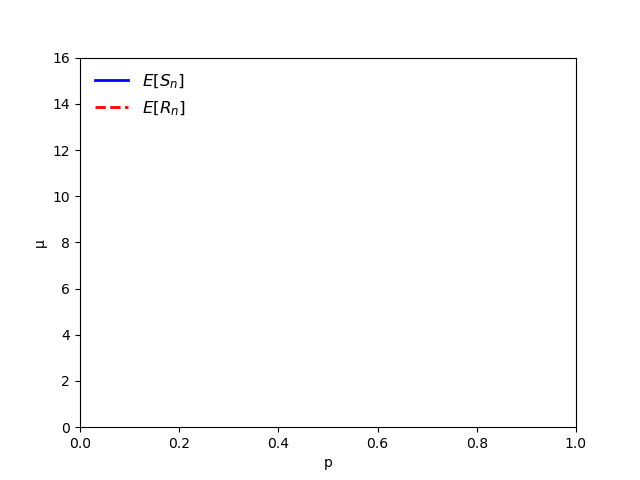

In [43]:
fig, ax = plt.subplots()

line1, = ax.plot([], [], lw=2, label=r'$E[S_n]$', color='blue')
line2, = ax.plot([], [], lw=2, label=r'$E[R_n]$', color='red', linestyle='--')

text_q = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                 ha='right', va='top', fontsize=12)

ax.set_xlim(P[:, 0].min(), P[:, 0].max())
ax.set_ylim(np.min(U4[:, :, :]), np.max(U4[:, :, :]))
ax.set_xlabel('p')
ax.set_ylabel(r'µ')
ax.legend(loc='upper left', fontsize=12, frameon=False)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    text_q.set_text('')
    return line1, line2, text_q

def update(frame):
    y1 = U4[0, :, frame]
    y2 = U4[1, :, frame]
    line1.set_data(P[:, 0], y1)
    line2.set_data(P[:, 0], y2)
    text_q.set_text(rf'$q = {Q[0, frame]:.3f}$')  # update q value
    ax.set_title(f'Frame {frame} of {Q[0, :].shape[0]-1}')
    return line1, line2, text_q

ani = animation.FuncAnimation(
    fig, update, frames=range(Q[0, :].shape[0]), init_func=init, blit=True, interval=16, repeat=True
)

plt.show()

#ani.save('plots/q_scan.mp4', writer='ffmpeg', fps=10)

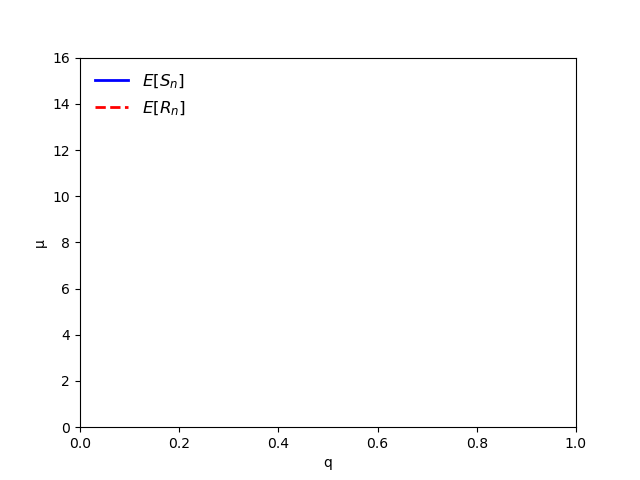

In [42]:
fig, ax = plt.subplots()

line1, = ax.plot([], [], lw=2, label=r'$E[S_n]$', color='blue')
line2, = ax.plot([], [], lw=2, label=r'$E[R_n]$', color='red', linestyle='--')

text_q = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                 ha='right', va='top', fontsize=12)

ax.set_xlim(Q[0, :].min(), Q[0, :].max())
ax.set_ylim(np.min(U4[:, :, :]), np.max(U4[:, :, :]))
ax.set_xlabel('q')
ax.set_ylabel(r'µ')
ax.legend(loc='upper left', fontsize=12, frameon=False)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    text_q.set_text('')
    return line1, line2, text_q

def update(frame):
    y1 = U4[0, frame, :]
    y2 = U4[1, frame, :]
    line1.set_data(Q[0, :], y1)
    line2.set_data(Q[0, :], y2)
    text_q.set_text(rf'$p = {P[frame, 0]:.3f}$')  # update q value
    ax.set_title(f'Frame {frame} of {P[:, 0].shape[0]-1}')
    return line1, line2, text_q

ani = animation.FuncAnimation(
    fig, update, frames=range(P[:, 0].shape[0]), init_func=init, blit=True, interval=16, repeat=True
)

plt.show()

ani.save('plots/p_scan_mu_even.mp4', writer='ffmpeg', fps=10)

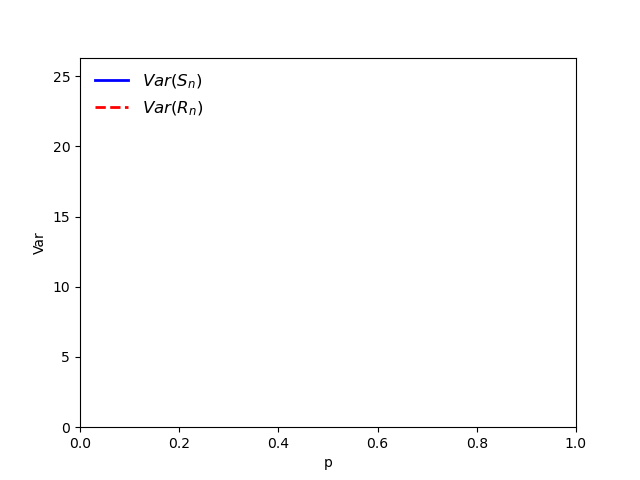

In [39]:
fig, ax = plt.subplots()

line1, = ax.plot([], [], lw=2, label=r'$Var(S_n)$', color='blue')
line2, = ax.plot([], [], lw=2, label=r'$Var(R_n)$', color='red', linestyle='--')

text_q = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                 ha='right', va='top', fontsize=12)

ax.set_xlim(P[:, 0].min(), P[:, 0].max())
ax.set_ylim(np.min(V4[[0,2], :, :]), np.max(V4[[0,2], :, :]))
ax.set_xlabel('p')
ax.set_ylabel(r'Var')
ax.legend(loc='upper left', fontsize=12, frameon=False)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    text_q.set_text('')
    return line1, line2, text_q

def update(frame):
    y1 = V4[0, :, frame]
    y2 = V4[2, :, frame]
    line1.set_data(P[:, 0], y1)
    line2.set_data(P[:, 0], y2)
    text_q.set_text(rf'$q = {Q[frame, 0]:.3f}$')  # update q value
    ax.set_title(f'Frame {frame} of {Q[0, :].shape[0]-1}')
    return line1, line2, text_q

ani = animation.FuncAnimation(
    fig, update, frames=range(Q[0, :].shape[0]), init_func=init, blit=True, interval=16, repeat=False
)

plt.show()

#ani.save('plots/q_scan.mp4', writer='ffmpeg', fps=10)

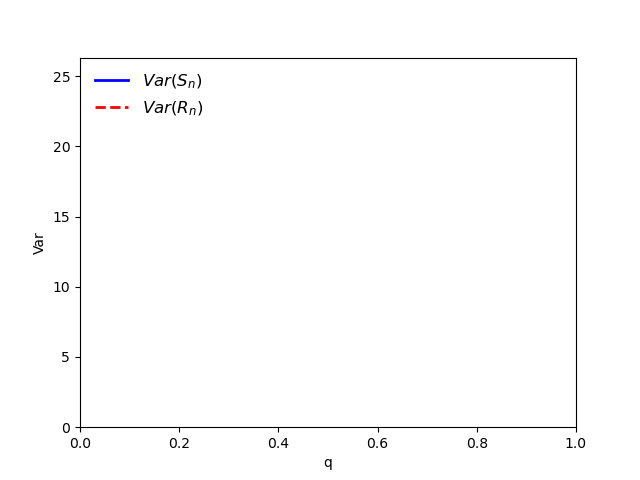

In [41]:
fig, ax = plt.subplots()

line1, = ax.plot([], [], lw=2, label=r'$Var(S_n)$', color='blue')
line2, = ax.plot([], [], lw=2, label=r'$Var(R_n)$', color='red', linestyle='--')

text_p = ax.text(0.95, 0.95, '', transform=ax.transAxes,
                 ha='right', va='top', fontsize=12)

ax.set_xlim(Q[0, :].min(), Q[0, :].max())
ax.set_ylim(np.min(V4[[0,2], :, :]), np.max(V4[[0,2], :, :]))
ax.set_xlabel('q')
ax.set_ylabel(r'Var')
ax.legend(loc='upper left', fontsize=12, frameon=False)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    text_p.set_text('')
    return line1, line2, text_p

def update(frame):
    y1 = V4[0, frame, :]
    y2 = V4[2, frame, :]
    line1.set_data(Q[0, :], y1)
    line2.set_data(Q[0, :], y2)
    text_p.set_text(rf'$p = {P[0, frame]:.3f}$')  # update p value
    ax.set_title(f'Frame {frame} of {P[0, :].shape[0]-1}')
    return line1, line2, text_p

ani = animation.FuncAnimation(
    fig, update, frames=range(P[0, :].shape[0]), init_func=init, blit=True, interval=100, repeat=False
)

plt.show()

#ani.save('plots/p_scan.mp4', writer='ffmpeg', fps=10)